## Attention-based CNN for OCT Cancer Detection
### This notebook implements an attention-based CNN with dropout and batch normalization to classify OCT scans and compare against a U-Net baseline.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive")
%pwd

Mounted at /content/drive


'/content/drive/MyDrive'

In [3]:
!unzip -q OCT.zip -d /content

In [4]:
%cd /content

/content


In [5]:
%ls

drive/  OCT/  sample_data/


In [28]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

## Reproducibility

In [29]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Attention Modules (CBAM)

In [30]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.mlp(self.avg_pool(x))
        max_out = self.mlp(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = 3 if kernel_size==7 else 1
        self.conv = nn.Conv2d(2,1,kernel_size,padding=padding,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out,_ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention(in_channels, reduction)
        self.spatial_att = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_att(x) * x
        x = self.spatial_att(x) * x
        return x

## Attention-based CNN Model

In [31]:
class AttentionCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=4):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3)
            )
        self.layer1 = conv_block(in_channels, 32)
        self.att1 = CBAMBlock(32)
        self.layer2 = conv_block(32, 64)
        self.att2 = CBAMBlock(64)
        self.layer3 = conv_block(64, 128)
        self.att3 = CBAMBlock(128)
        self.layer4 = conv_block(128, 256)
        self.att4 = CBAMBlock(256)
        self.pool = nn.MaxPool2d(2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.att1(x)
        x = self.pool(x)
        x = self.layer2(x)
        x = self.att2(x)
        x = self.pool(x)
        x = self.layer3(x)
        x = self.att3(x)
        x = self.pool(x)
        x = self.layer4(x)
        x = self.att4(x)
        x = self.global_pool(x).view(x.size(0), -1)
        return self.classifier(x)


## Dataset & Dataloader

In [32]:
class OCTClassificationDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.transform = transform
        self.images = []
        classes = sorted(os.listdir(os.path.join(root_dir, split)))
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            for fname in os.listdir(os.path.join(root_dir, split, cls)):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.images.append((os.path.join(root_dir, split, cls, fname), self.class_to_idx[cls]))

    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        path, label = self.images[idx]
        img = Image.open(path).convert('L')
        if self.transform: img = self.transform(img)
        return img, label


## Transforms and DataLoaders

In [33]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

root = 'OCT'
full_ds = OCTClassificationDataset(root, 'train', transform)
fraction = 0.2
max_samples = int(len(full_ds) * fraction)
train_ds, _ = random_split(full_ds, [max_samples, len(full_ds) - max_samples])

# test uses deterministic transform
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])
test_ds = OCTClassificationDataset(root, 'test', test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)


## Setup Model, Loss, Optimizer, Schedule

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionCNN(in_channels=1, num_classes=len(full_ds.class_to_idx)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training & Validation Functions

In [35]:
def train_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)


def eval_model(model, loader):
    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

## Training Loop

In [36]:
num_epochs = 10
history = {'train_loss':[], 'test_loss':[], 'test_acc':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    test_loss, test_acc = eval_model(model, test_loader)
    scheduler.step(test_loss)
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}  Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")


100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


Epoch 1/10  Train Loss: 0.6511  Test Loss: 1.7734  Test Acc: 0.3630


100%|██████████| 32/32 [00:04<00:00,  7.92it/s]


Epoch 2/10  Train Loss: 0.4395  Test Loss: 2.4258  Test Acc: 0.3940


100%|██████████| 32/32 [00:04<00:00,  7.92it/s]


Epoch 3/10  Train Loss: 0.2976  Test Loss: 1.7229  Test Acc: 0.5560


100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


Epoch 4/10  Train Loss: 0.2339  Test Loss: 2.0517  Test Acc: 0.6490


100%|██████████| 32/32 [00:04<00:00,  7.66it/s]


Epoch 5/10  Train Loss: 0.2058  Test Loss: 1.5600  Test Acc: 0.5480


100%|██████████| 32/32 [00:04<00:00,  7.44it/s]


Epoch 6/10  Train Loss: 0.1892  Test Loss: 1.5191  Test Acc: 0.6020


100%|██████████| 32/32 [00:05<00:00,  5.87it/s]


Epoch 7/10  Train Loss: 0.1788  Test Loss: 1.6858  Test Acc: 0.7160


100%|██████████| 32/32 [00:04<00:00,  7.85it/s]


Epoch 8/10  Train Loss: 0.1749  Test Loss: 1.2844  Test Acc: 0.7280


100%|██████████| 32/32 [00:04<00:00,  7.90it/s]


Epoch 9/10  Train Loss: 0.1636  Test Loss: 1.5920  Test Acc: 0.6580


100%|██████████| 32/32 [00:05<00:00,  5.67it/s]

Epoch 10/10  Train Loss: 0.1649  Test Loss: 1.2492  Test Acc: 0.7060


## Plot Training Curves

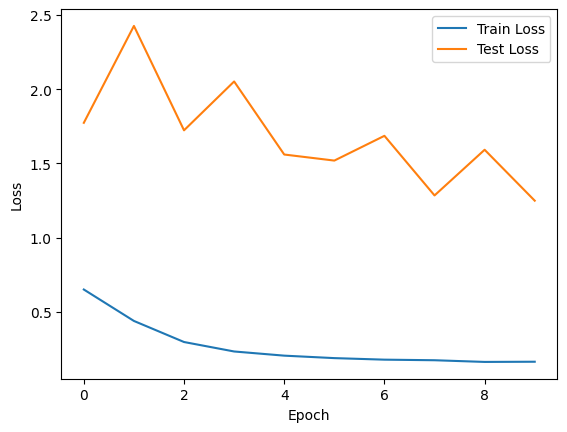

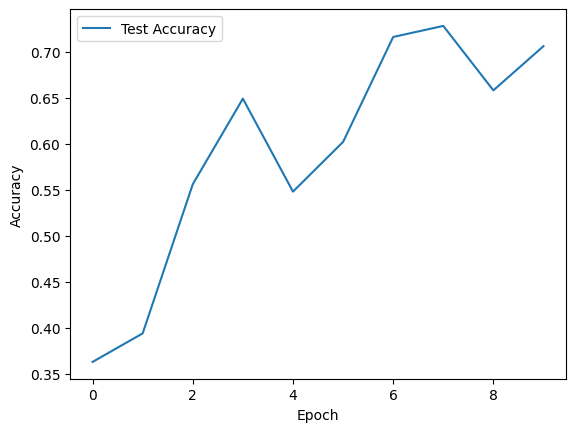

In [37]:
plt.figure()
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Detailed Evaluation

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


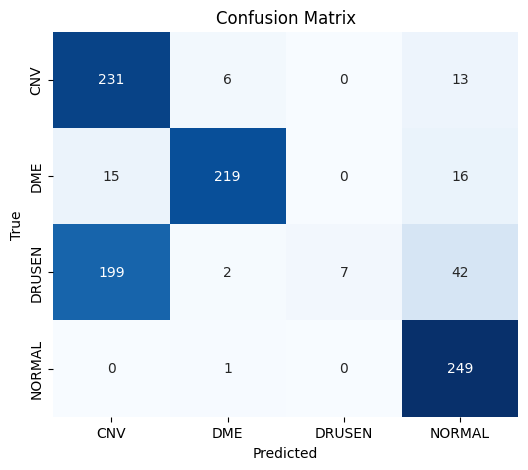

Classification Report:

              precision    recall  f1-score   support

         CNV       0.52      0.92      0.66       250
         DME       0.96      0.88      0.92       250
      DRUSEN       1.00      0.03      0.05       250
      NORMAL       0.78      1.00      0.87       250

    accuracy                           0.71      1000
   macro avg       0.81      0.71      0.63      1000
weighted avg       0.81      0.71      0.63      1000

ROC AUC by class: {'CNV': np.float64(0.903312), 'DME': np.float64(0.9940373333333333), 'DRUSEN': np.float64(0.9897653333333334), 'NORMAL': np.float64(0.9924586666666667)}


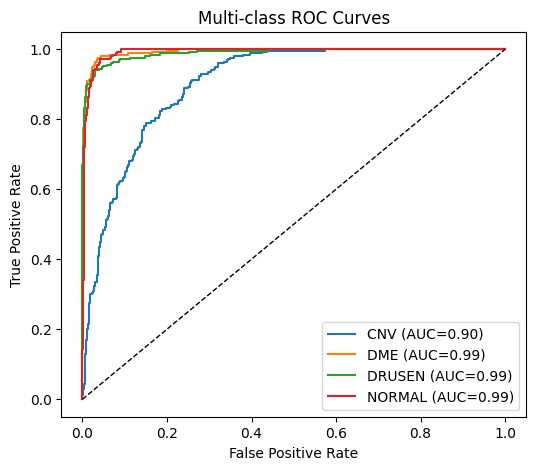

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


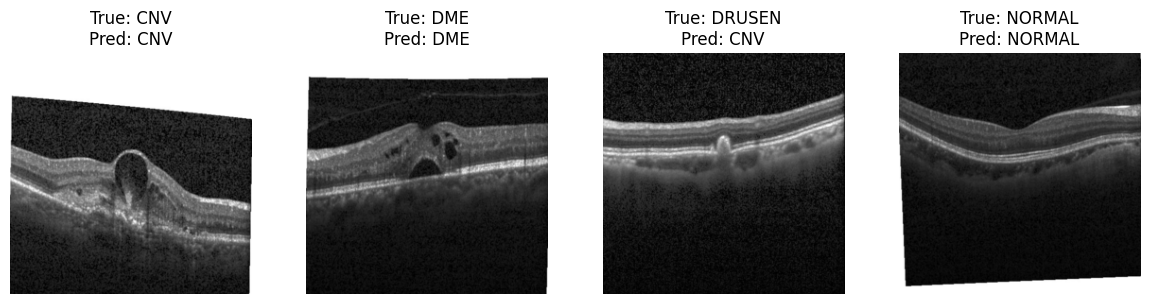

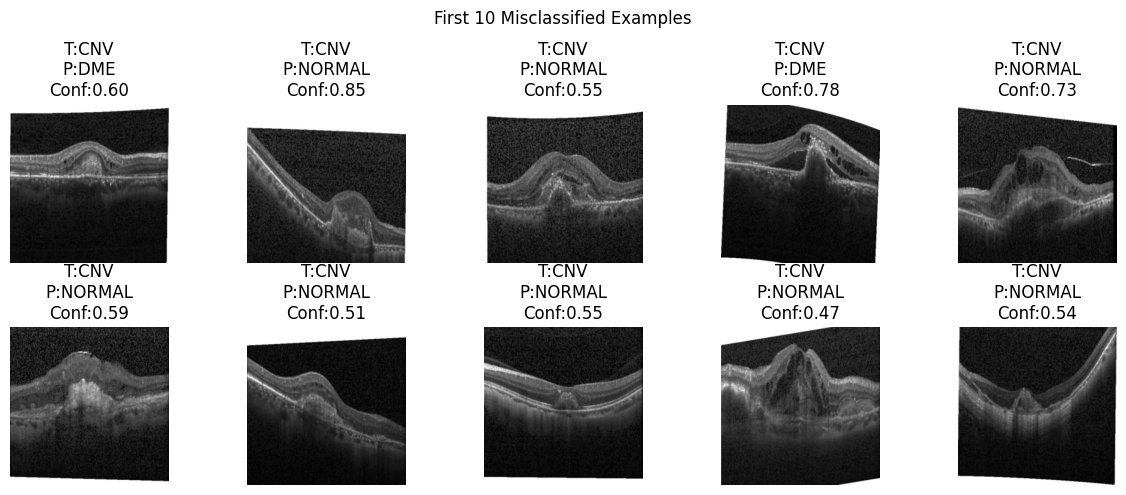

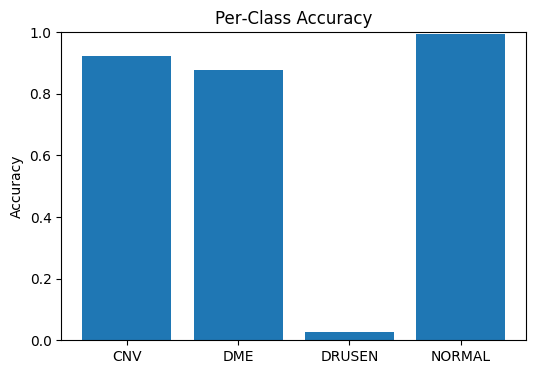

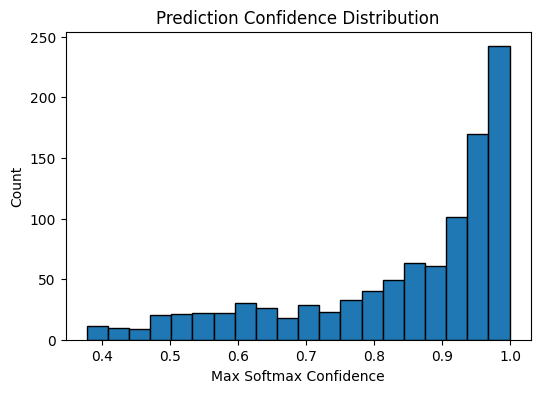

In [40]:
# --- EVALUATION SECTION (no retraining) ---
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

# build idx→class map
idx_to_class = {v:k for k,v in full_ds.class_to_idx.items()}
class_names   = [idx_to_class[i] for i in range(len(idx_to_class))]
num_classes   = len(class_names)

# gather all labels, preds, and softmax-probs
all_labels = []
all_preds  = []
all_probs  = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs   = torch.softmax(outputs, dim=1).cpu().numpy()
        preds   = probs.argmax(axis=1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

# 1) Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 2) Classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds,
                            target_names=class_names))

# 3) ROC AUC per class + Curves (One-vs-Rest)
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
roc_auc = {
    class_names[i]:
    roc_auc_score(y_true_bin[:,i], all_probs[:,i])
    for i in range(num_classes)
}
print("ROC AUC by class:", roc_auc)

plt.figure(figsize=(6,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:,i], all_probs[:,i])
    plt.plot(fpr, tpr,
             label=f"{class_names[i]} (AUC={roc_auc[class_names[i]]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi‐class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# 4) One example per true class
examples = {}
for imgs, labels in test_loader:
    outputs = model(imgs.to(device))
    preds   = outputs.argmax(dim=1).cpu().numpy()
    for img, true, pred in zip(imgs, labels.numpy(), preds):
        if true not in examples:
            examples[true] = (img.cpu(), true, pred)
        if len(examples) == num_classes:
            break
    if len(examples) == num_classes:
        break

fig, axes = plt.subplots(1, num_classes, figsize=(num_classes*3,3))
for cls_idx, ax in enumerate(axes):
    img, true, pred = examples[cls_idx]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# 5) Misclassified examples (first 10)
mis = []
with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = model(imgs.to(device))
        probs   = torch.softmax(outputs, dim=1).cpu().numpy()
        preds   = probs.argmax(axis=1)
        for img, true, pred, p in zip(imgs.cpu(), labels.numpy(), preds, probs):
            if pred != true:
                mis.append((img, true, pred, p[pred]))
            if len(mis) >= 10:
                break
        if len(mis) >= 10:
            break

fig, axes = plt.subplots(2,5, figsize=(12,5))
for ax, (img, true, pred, conf) in zip(axes.flatten(), mis):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"T:{class_names[true]}\nP:{class_names[pred]}\nConf:{conf:.2f}")
    ax.axis('off')
plt.suptitle("First 10 Misclassified Examples")
plt.tight_layout()
plt.show()

# 6) Class‐wise accuracy bar plot
class_acc = np.diag(cm) / cm.sum(axis=1)
plt.figure(figsize=(6,4))
plt.bar(class_names, class_acc)
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Per‐Class Accuracy')
plt.show()

# 7) Prediction confidence distribution
confidences = all_probs.max(axis=1)
plt.figure(figsize=(6,4))
plt.hist(confidences, bins=20, edgecolor='k')
plt.xlabel('Max Softmax Confidence')
plt.ylabel('Count')
plt.title('Prediction Confidence Distribution')
plt.show()


## Save Model


In [41]:
torch.save(model.state_dict(), 'attention_cnn.pth')